In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import math
import time
import os
import sys

In [0]:
def vgg_block(num_convs, in_channels, out_channels):
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    
    blk = nn.Sequential(*layers)
    
    return blk

In [0]:
 conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
def vgg(conv_arch):
    # The convulational layer part
    conv_layers=[]
    in_channels=1
    
    for (num_convs, out_channels) in conv_arch:
        conv_layers.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    net=nn.Sequential(
                      *conv_layers,
                      # The fully connected layer part
                      Flatten(),
                      nn.Linear(in_features=512*7*7, out_features=4096),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(4096, 4096),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(4096, 10)
                     )
    return net

net = vgg(conv_arch)

In [5]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [6]:

X = torch.randn(size=(1,1,224,224), dtype=torch.float32)
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [0]:
n_epochs = 2
batch_size_train = 32
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [8]:
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.pytorch', 'datasets', 'fashion-mnist')):
    """Download the Fashion-MNIST dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [transforms.Resize(resize)]
    transformer += [transforms.ToTensor()]
    transformer = transforms.Compose(transformer)

    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, transform=transformer, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, transform=transformer, download=True)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter =torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
    test_iter =torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter
batch_size =64
train_loader, test_loader = load_data_fashion_mnist(batch_size, resize=224)

0it [00:00, ?it/s]

26427392it [00:01, 13640065.11it/s]                             


Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 92536.09it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw


4423680it [00:01, 3921141.79it/s]                             
0it [00:00, ?it/s]

Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw


8192it [00:00, 16172.69it/s]            

Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw
Processing...
Done!


In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 224, 224])

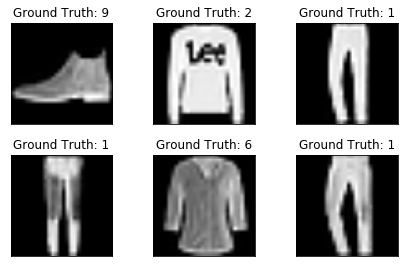

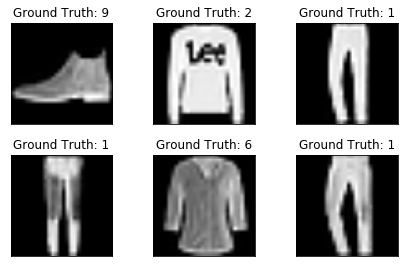

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    
    output = network(data)
    loss = F.nll_loss(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [0]:

network = net
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [0]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(
        (batch_idx*64) + ((epoch-1)*len(test_loader.dataset)))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


In [0]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.000726
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.026675
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.054465
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.081929
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.112627
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.138184
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.167113
